# Machine Annotation - Round 1 - BERTimbau - Relevance


---

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Hugging Face - Transformers


In [2]:
!pip install transformers

In [3]:
# Importing some libraries

from transformers import BertForSequenceClassification, BertTokenizer, pipeline

## Dataset - Relevance

---

**CHANGE FILE PATH HERE TO TRAIN WITH A DIFFERENT DATASET:**

In [4]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

# Only 2020
df20 = pd.read_csv('/content/drive/MyDrive/pesquisa-usp/relevant_tweets_2020-12-31.csv')

df20

,tweet_id,content,post_date,relevance
0,A522,A cabeça pensa onde o pé pisa. Quem governa de...,2020-09-15,relevant
1,A457,Sarto vai fazer um grande Programa de Enfrenta...,2020-11-20,relevant
2,A445,A Câmara dos Deputados votou hoje a MP que tra...,2020-12-18,relevant
3,A546,Tirar Bolsonaro do poder é uma questão de vida...,2020-11-10,relevant
4,A847,E a LIESA decidiu adiar os desfiles do #Carnav...,2020-09-24,relevant
...,...,...,...,...
2997,B2717,"""Estou exigindo a questão da cloroquina."" Algu...",2020-05-14,relevant
2998,B4586,#FeijoadaBeneficente | Participei neste sábado...,2020-03-09,irrelevant
2999,B4134,Aracaju tem um legado. Legado de desenvolvimen...,2020-06-10,irrelevant
3000,B2705,Estudo publicado pelo Imperial College estima ...,2020-04-01,irrelevant


**GLOBAL VARIABLES FOR COLUMN NAMES** \\
RELEVANCE = name of column representing relevance \\
RELEVANCE_ID = column value that represents (relevance == True) \\

POST = name of column representing the content of the tweet \\
POST_DATA = name of column representing the post date \\
POST_ID = name of column representing the tweet id

In [5]:
RELEVANCE = 'relevance'
RELEVANCE_ID = 'relevant'

POST = 'content'
POST_DATE = 'post_date'
POST_ID = 'tweet_id'

In [6]:
print(df20[RELEVANCE].dtype, df20[POST].dtype)

# print("\nrelevance column:\n",df20[RELEVANCE])

# print("\npost column:\n", df20[POST])

object object


In [7]:
print("Tweet_Relevancies 2020:")

print(df20[RELEVANCE].value_counts())

# Class Distribution

Tweet_Relevancies 2020:
relevance
irrelevant    1595
relevant      1407
Name: count, dtype: int64


In [8]:
df = df20

###  Parsing

In [9]:

#  Transforming Relevance into an integer
#  Brownlee (2020, p.16) -> Majority as 0, minority as 1

def condition(x):
    if x == RELEVANCE_ID:
        return 1
    else:
        return 0

df[RELEVANCE] = df[RELEVANCE].apply(condition)

# Class Distributions

print(df[RELEVANCE].value_counts())

relevance
0    1595
1    1407
Name: count, dtype: int64


### Train Test Set Split

Here, we separate 10% of the total observations for the test set. \\

Train and Test sets should be tokenized and processed separately to avoid data leakage. \\

We also used a stratifier for the split to ensure that there is a proportionality of classes over train and test (and, futhermore, on the validation sets).

In [10]:
from torch.utils.data import TensorDataset, random_split, Subset, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split

# changes made for relevance:
df_train, df_test = train_test_split(df,
                                     test_size = 0.1, # 10% for the test set
                                     stratify = df[RELEVANCE], # Strat
                                     random_state = 42)
print("training set class distribution:")
print(df_train[RELEVANCE].value_counts())
print("\ntest set class distribution:")
print(df_test[RELEVANCE].value_counts())

training set class distribution:
relevance
0    1435
1    1266
Name: count, dtype: int64

test set class distribution:
relevance
0    160
1    141
Name: count, dtype: int64


### Class Distribution Over Folds

Checking the distribution of classes over folds. You can ignore this part.

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle

# Initiating Stratified Kfold

skf = StratifiedKFold(n_splits = 5,
                     shuffle = True,
                     random_state = 42)


# Shuffle

df_train2 = shuffle(df_train)


# QUESTION:
y = df_train[RELEVANCE]

# Note:
# Each fold is a tuple ([train_index_values], [val_index_values])
# fold_0, fold_1, fold_2, fold_3, fold_5 = kf.split(df, y)

# Put the folds into a list. This is a list of tuples.

fold_list = list(skf.split(df_train2,y))

train_df_list = []
val_df_list = []

for i, fold in enumerate(fold_list):

  # Map the train and val index values to dataframe rows
  df_train2 = df[df.index.isin(fold[0])]
  df_val = df[df.index.isin(fold[1])]

  train_df_list.append(df_train2)
  val_df_list.append(df_val)



print(len(train_df_list))
print(len(val_df_list))

5
5


Creates 5 folds, each with different train and validation sets

In [15]:
target = df_train.loc[:,RELEVANCE]
fold_no = 1

for train_index, val_index in skf.split(df_train, target):
  train = df_train.iloc[train_index,:]

  validation = df_train.iloc[val_index,:]

  print('\nTrain in Fold',str(fold_no),'\n', train[RELEVANCE].value_counts())
  print('Validation in Fold',str(fold_no),'\n', validation[RELEVANCE].value_counts())
  fold_no += 1



Train in Fold 1 
 relevance
0    1148
1    1012
Name: count, dtype: int64
Validation in Fold 1 
 relevance
0    287
1    254
Name: count, dtype: int64

Train in Fold 2 
 relevance
0    1148
1    1013
Name: count, dtype: int64
Validation in Fold 2 
 relevance
0    287
1    253
Name: count, dtype: int64

Train in Fold 3 
 relevance
0    1148
1    1013
Name: count, dtype: int64
Validation in Fold 3 
 relevance
0    287
1    253
Name: count, dtype: int64

Train in Fold 4 
 relevance
0    1148
1    1013
Name: count, dtype: int64
Validation in Fold 4 
 relevance
0    287
1    253
Name: count, dtype: int64

Train in Fold 5 
 relevance
0    1148
1    1013
Name: count, dtype: int64
Validation in Fold 5 
 relevance
0    287
1    253
Name: count, dtype: int64


## Model Configs, Dataloader and Training


---

Here we have the main hyperparameters and configurations of the model. \\

If you'd like, you can tweak the learning rate (L_RATE), maximum length of the vectors (MAX_LEN), Batch Size and the EPS of the Adam Otimizer. I think the number of folds and epochs will mostly remain the same. \\
 \\
**eps (float, optional)** – term added to the denominator to improve numerical stability (default: 1e-8)

### Configs

In [16]:
import os


# BERTimbau
MODEL_TYPE = 'neuralmind/bert-base-portuguese-cased'


# Configs
NUM_FOLDS = 5
NUM_FOLDS_TO_TRAIN = 5

L_RATE = 2e-5 # Testar novos valores
MAX_LEN = 256 # Testar novos valores
BATCH_SIZE = 32
EPS = 1e-8

NUM_EPOCHS = 5
NUM_CORES = os.cpu_count()

NUM_CORES

2

GPU

In [17]:
import torch

# If there's a GPU available:
if torch.cuda.is_available():

    # Use GPU
    device = torch.device("cuda")

    print("There are available GPU(s).") # torch.cuda.device_cour

    print("We will use the GPU:", torch.cuda.get_device_name(0))

# If not

else:
    print("No GPU available, using CPU")
    device = torch.device("cpu")

No GPU available, using CPU


### BERTimbau Tokenizer

In [18]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained(MODEL_TYPE, do_lower_case=True)

Loading BERT tokenizer...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

### Creating the Dataloader


#### Dataset Custom Classes

In [19]:
# back to OG:
from torch.utils.data import Dataset


class CompDataset(Dataset):

  def __init__(self, df):
    self.df_data = df


  def __getitem__(self, index):

    # Get the sentences from the dataframe
    sentence = self.df_data.loc[index, POST]


    # Transform the sentence

    encoded_dict = tokenizer.encode_plus(sentence,  # Sentences to be tokenized
                                         add_special_tokens = True, # [CLS] and [SEP]
                                         padding = 'max_length',
                                         max_length = MAX_LEN,
                                         return_attention_mask = True, # Build attn. masks.
                                         return_tensors = 'pt', # Return pytorch tensors
                                        )


    # Torch Tensors

    padded_token_list = encoded_dict['input_ids'][0]
    att_mask = encoded_dict['attention_mask'][0]
    token_type_ids = encoded_dict['token_type_ids'][0]


    # Transforming the Target into a tensor

    target = torch.tensor(self.df_data.loc[index, RELEVANCE])

    sample = (padded_token_list, att_mask, token_type_ids, target)

    return sample


  def __len__(self):

    return len(self.df_data)



# Doing the same for the test dataset

class TestDataset(Dataset):

  def __init__(self, df):
    self.df_data = df


  def __getitem__(self, index):

    #  Get the sentences from the dataframe
    sentence = self.df_data.iloc[index, self.df_data.columns.get_loc(POST)]


    # Transform the sentence

    encoded_dict = tokenizer.encode_plus(sentence,  # Sentences to be tokenized
                                         add_special_tokens = True, # [CLS] and [SEP]
                                         padding = 'max_length',
                                         max_length = MAX_LEN,
                                         return_attention_mask = True, # attn. masks.
                                         return_tensors = 'pt', # Return Pytorch Tensors
                                        )


    padded_token_list = encoded_dict['input_ids'][0]
    att_mask = encoded_dict['attention_mask'][0]
    token_type_ids = encoded_dict['token_type_ids'][0]


    # Transforming the target into a tensor

    target = torch.tensor(self.df_data.iloc[index, self.df_data.columns.get_loc(RELEVANCE)])

    sample = (padded_token_list, att_mask, token_type_ids, target)

    return sample


  def __len__(self):

    return len(self.df_data)

#### Testing the Dataloader

In [ ]:
df_train2, df_val2 = train_test_split(df, test_size = 0.2, stratify = df[RELEVANCE], random_state = 42)


df_train2 = df_train.reset_index(drop=True)
df_val2 = df_val.reset_index(drop = True)


print('Training Set Size: ', len(df_train2))
print('Distribution of classes in Training')

# changes for relevance:
# print(df_train2['positions_vac'].value_counts())
print(df_train2[RELEVANCE].value_counts())

print(" ")

print('Validation Set Size: ', len(df_val2))
print('Distribution of classes in Validation')

# changes for relevance:
print(df_val2[RELEVANCE].value_counts())
# print(df_val2['positions_vac'].value_counts())



Training Set Size:  1441
Distribution of classes in Training
Corrected_relevante
1    871
0    570
Name: count, dtype: int64
 
Validation Set Size:  288
Distribution of classes in Validation
Corrected_relevante
1    199
0     89
Name: count, dtype: int64


In [ ]:
from torch.utils.data import DataLoader

train_data = CompDataset(df_train2)
val_data = CompDataset(df_val2)
test_data = TestDataset(df_test)

train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

val_dataloader = DataLoader(val_data,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)



print(len(train_dataloader))
print(len(val_dataloader))
print(len(test_dataloader))

46
9
6


In [ ]:
# # Get one train batch

padded_token_list, att_mask, token_type_ids, target = next(iter(train_dataloader))

print(padded_token_list.shape)
print(att_mask.shape)
print(token_type_ids.shape)
print(target.shape)


torch.Size([32, 256])
torch.Size([32, 256])
torch.Size([32, 256])
torch.Size([32])


In [ ]:
# Get one val batch

padded_token_list, att_mask, token_type_ids, target = next(iter(val_dataloader))

print(padded_token_list.shape)
print(att_mask.shape)
print(token_type_ids.shape)
print(target.shape)

torch.Size([32, 256])
torch.Size([32, 256])
torch.Size([32, 256])
torch.Size([32])


In [ ]:
# Get one test batch


padded_token_list, att_mask, token_type_ids, target = next(iter(test_dataloader))

print(padded_token_list.shape)
print(att_mask.shape)
print(token_type_ids.shape)
print(target.shape)

torch.Size([32, 256])
torch.Size([32, 256])
torch.Size([32, 256])
torch.Size([32])


## Model


---

Here is the model used for training (you can check the name of the model on the MODEL_TYPE variable). Don't forget to adjust the number of labels if you need.

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    MODEL_TYPE,
    num_labels = 2, # Change the number of classes accordingly
    output_attentions = False)

# Send the model to the device.
model.to(device)

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

#### Testing the model

Checking if everything is all right with the model, you can safely ignore.

In [ ]:
# Get one train batch

train_dataloader = torch.utils.data.DataLoader(train_data,
                                        batch_size=8,
                                        shuffle=True,
                                       num_workers=NUM_CORES)

batch = next(iter(train_dataloader))

b_input_ids = batch[0].to(device)
b_input_mask = batch[1].to(device)
b_token_type_ids = batch[2].to(device)
b_labels = batch[3].to(device)



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
outputs = model(b_input_ids,
                token_type_ids=b_token_type_ids,
                attention_mask=b_input_mask,
                labels=b_labels)

In [ ]:
outputs

SequenceClassifierOutput(loss=tensor(0.6732, device='cuda:0', grad_fn=<NllLossBackward0>), logits=tensor([[-0.0869, -0.1997],
        [ 0.2034, -0.0382],
        [ 0.1238,  0.1890],
        [ 0.0268, -0.0865],
        [-0.0729, -0.2061],
        [ 0.0907, -0.1190],
        [ 0.1374, -0.0007],
        [ 0.0574, -0.1752]], device='cuda:0', grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [ ]:
# Predictions

outputs[1]

tensor([[-0.0869, -0.1997],
        [ 0.2034, -0.0382],
        [ 0.1238,  0.1890],
        [ 0.0268, -0.0865],
        [-0.0729, -0.2061],
        [ 0.0907, -0.1190],
        [ 0.1374, -0.0007],
        [ 0.0574, -0.1752]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
preds = outputs[1].detach().cpu().numpy()

y_true = b_labels.detach().cpu().numpy()
y_pred = np.argmax(preds, axis = 1)

y_pred

array([0, 0, 1, 0, 0, 0, 0, 0])

#### Evaluation of Pre-Fine-Tuned Model

Metrics: accuracy, precision, recall, f1-score and confusion matrix

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score


# This is the accuracy without any fine tuning.

val_acc = accuracy_score(y_true, y_pred)

val_acc

0.625

#### Metrics

Main metrics used here are the classification report (which outputs precision, recall and f1-score per class) and the overall accuracy. We also computate the f1-macro on the training loop.

In [ ]:
# Metrics

from sklearn.metrics import accuracy_score, f1_score, classification_report

# Accuracy

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Classification report
def classification_report_with_accuracy_score(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    # labels_flat = labels.flatten()
    report = classification_report(labels, pred_flat, output_dict = True, zero_division = 0)
    df_class_report = pd.DataFrame(report).transpose()
    return df_class_report

#### Training the model

Here is the code that will do the training of the model, read it carefully and you can ask me questions if needed.

In [ ]:
%%time

from transformers import AdamW
import random
import gc

# Remove Warning

from transformers import logging

logging.set_verbosity_warning()



# Set a seed value.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Num folds
NUM_FOLDS_TO_TRAIN = 5
NUM_FOLDS = 5


# Kfold
skf = StratifiedKFold(n_splits = 5,
                     shuffle = True,
                     random_state = 42)



# Store the accuracy scores for each fold model in this list.
# [[model_0 scores], [model_1 scores], [model_2 scores], [model_3 scores], [model_4 scores]]
# [[ecpoch 1, epoch 2, ...], [ecpoch 1, epoch 2, ...], [ecpoch 1, epoch 2, ...], [ecpoch 1, epoch 2, ...], [ecpoch 1, epoch 2, ...]]

# Create a list of lists to store the val acc results.
# The number of items in this list will correspond to
# the number of folds that the model is being trained on.

fold_val_acc_list = []
fold_val_f1macro_list = []


# Saving some values
# validation accuracy, and timings.

training_stats = []
clf_report = pd.DataFrame()


for i in range(0, NUM_FOLDS):

    # append an empty list
    fold_val_acc_list.append([])
    fold_val_f1macro_list.append([])



for fold_index, (train_index, val_index) in enumerate(skf.split(df_train,y)):

  print("\nNum folds used for training:", NUM_FOLDS_TO_TRAIN)
  print('\n################## Fold Model Number', fold_index, '##################')

  # ...........................................................................
  # Defining Dataloaders of Training and Validation
  # ...........................................................................


  # Train and Validation Sets
  train = df_train.iloc[train_index,:]
  val = df_train.iloc[val_index,:]


  # Reseting Indexes so it will work
  train_res = train.reset_index(drop = True)
  val_res = val.reset_index(drop = True)


  # Checking class proportions for each set
  print('Fold: ', fold_index, "\n Train Set Size: ", len(train_res))
  print(train_res[RELEVANCE].value_counts())
  print('Fold: ', fold_index, '\n Validation Set Size: ', len(val_res))
  print(val_res[RELEVANCE].value_counts())


  # Tokenizing and Transforming Inputs (att masks, labels, etc.)
  train_data = CompDataset(train_res)
  val_data = CompDataset(val_res)

  # Creating Dataloaders for this Fold/Run
  train_dataloader = torch.utils.data.DataLoader(train_data,
                                                   batch_size=BATCH_SIZE,
                                                   shuffle=True,
                                                   num_workers=NUM_CORES)

  val_dataloader = torch.utils.data.DataLoader(val_data,
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=False,
                                                 num_workers=NUM_CORES)

  # Getting number of folders
  num_folds = len(train_df_list)

# For each Epoch


#------------------------------------------------------------------------------
  for epoch in range(0, NUM_EPOCHS):
#------------------------------------------------------------------------------

    #......................
    # Loading Fold Model
    #......................

    if epoch == 0:

      # Defining the model
      model = BertForSequenceClassification.from_pretrained(
          MODEL_TYPE,
          num_labels = 2,
          output_attentions = False,
          output_hidden_states = False,
          )

      # Send the model to the device.

      model.to(device)

      optimizer = AdamW(model.parameters(),
                        lr = L_RATE,
                        eps = EPS
                        )

    else:

      # Getting the fold model
      path_model = 'model_' + str(fold_index) + '.bin'

      if os.path.exists(path_model):
        model.load_state_dict(torch.load(path_model))

      else:
        print(f"Error: {path_model} does not exist")

      # enviar o modelo para o device.
        model.to(device)


    print('============== Epoch {:} / {:} =============='.format(epoch + 1, NUM_EPOCHS))

    # For this epoch, store the val acc scores for each fold in this list.
    # We will use this list to calculate the cv at the end of the epoch.
    epoch_acc_scores_list = []

    # ==========================================================================
    #               Training
    # ==========================================================================

    stacked_val_labels = []
    targets_list = []

    print(" ")
    print('\nTraining...')
    print('')

    # put the model into train mode
    model.train()

    # This turns gradient calculations on and off.
    torch.set_grad_enabled(True)


    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Tracking variables
    total_f1_score = 0
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0


    for i, batch in enumerate(train_dataloader):

      train_status = 'Batch ' + str(i+1) + ' of ' + str(len(train_dataloader))

      print(train_status, end='\r')


      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_token_type_ids = batch[2].to(device)
      b_labels = batch[3].to(device)

      model.zero_grad()


      loss, logits = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           return_dict = False,
                           labels=b_labels)

      # Convert the loss from a torch tensor to a number.
      # Calculate the total loss.
      total_train_loss = total_train_loss + loss.item()

      # Zero the gradients
      optimizer.zero_grad()

      # Perform a backward pass to calculate the gradients.
      loss.backward()

      # Clip the norm of the gradients to 1.0.
      # This is to help prevent the "exploding gradients" problem.
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # Use the optimizer to update Weights

      # Optimizer for GPU
      optimizer.step()

      # Optimizer for TPU
      # https://pytorch.org/xla/
      #xm.optimizer_step(optimizer, barrier=True)


    avg_train_loss = total_train_loss / len(train_dataloader)

    print('Total Train loss:' ,total_train_loss)
    print('Average Train Loss: ', avg_train_loss)


    # ==========================================================================
    #               Validation
    # ==========================================================================
    print(" ")
    print('=============================================')
    print('\nValidation...')
    print(' ')

    # Put the model in evaluation mode.
    model.eval()

    # Turn off the gradient calculations.
    # This tells the model not to compute or store gradients.
    # This step saves memory and speeds up validation.
    torch.set_grad_enabled(False)


    # Reset the total loss for this epoch.
    total_val_loss = 0

    # Tracking variables
    total_f1_score = 0
    total_weig_f1 = 0
    total_macro_f1 = 0
    total_eval_accuracy = 0
    total_eval_loss = 0


    for j, val_batch in enumerate(val_dataloader):

      val_status = 'Batch ' + str(j+1) + ' of ' + str(len(val_dataloader))

      print(val_status, end='\r')

      b_input_ids = val_batch[0].to(device)
      b_input_mask = val_batch[1].to(device)
      b_token_type_ids = val_batch[2].to(device)
      b_labels = val_batch[3].to(device)


      loss, logits = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           return_dict = False,
                           labels=b_labels)

      # Convert the loss from a torch tensor to a number.
      # Calculate the total loss.
      total_val_loss = total_val_loss + loss.item()


      # Move preds to the CPU
      val_preds = logits.detach().cpu().numpy()

      # Move the labels to the cpu
      targets_np = b_labels.to('cpu').numpy()

      # Append the labels to a numpy list
      targets_list.extend(targets_np)

      if j == 0: # Para o primeiro batch
        stacked_val_preds = val_preds

      else:
        stacked_val_preds = np.vstack((stacked_val_preds, val_preds))


      # Calculate the accuracy for this batch of test sentences, and
      # accumulate it over all batches. '
      total_eval_accuracy += flat_accuracy(val_preds, targets_np)
      total_f1_score += f1_score(np.argmax(val_preds,axis=1),
                                 targets_np,
                                 average = 'micro')

      total_weig_f1 += f1_score(np.argmax(val_preds, axis = 1),
                                  targets_np,
                                  average = 'weighted')


      total_macro_f1 += f1_score(np.argmax(val_preds, axis = 1),
                                  targets_np,
                                  average = 'macro')



    # .........................................................................
    # Calculate the validation accuracy for this fold
    # .........................................................................


    # Calculate the validation accuracy
    y_true = targets_list
    y_pred = np.argmax(stacked_val_preds, axis=1)


    # Sklearn Accuracy
    val_acc = accuracy_score(y_true, y_pred)

    # Flat Accuracy
    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # F1-score (Micro)
    avg_f1_score = total_f1_score / len(val_dataloader)
    print("  F1_score: {0:.2f}".format(avg_f1_score))

    # Macro F1
    avg_macro_f1 = total_macro_f1 / len(val_dataloader)
    print(" Macro F1-score: {0:.2f}".format(avg_macro_f1))

    # Weighted F1
    avg_weig_f1 = total_weig_f1 / len(val_dataloader)
    print(" Weighted F1-score: {0:.2f}".format(avg_weig_f1))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_val_loss / len(val_dataloader)


    # Class_report

    class_report = classification_report_with_accuracy_score(stacked_val_preds, y_true)

    # epoch_acc_scores_list.append(val_acc)
    epoch_acc_scores_list.append(avg_macro_f1)


    print('Val. loss:' ,total_val_loss)
    print('Val. acc: ', val_acc)
    print('Val. F1_Score', avg_f1_score)
    print('Classification Report: \n', class_report)


    # Training Report

    training_stats.append(
        {
            'epoch': epoch + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'f1_score_micro' : avg_f1_score,
            'macro_f1_score' : avg_macro_f1,
            'weighted_f1_score': avg_weig_f1,
            'classification_report':class_report,
            'fold' : fold_index

        }
      )


    classif_report = pd.DataFrame({'epoch': epoch + 1,
                                    'fold': fold_index,
                                    'class_report': [class_report]})


    # .........................................................................
    # Save the best model
    # .........................................................................

    if epoch == 0:

      # Save the Model
      model_name = 'model_' + str(fold_index) + '.bin'
      torch.save(model.state_dict(), model_name)
      print('Saved model as ', model_name)

    if epoch != 0:

      val_acc_list = fold_val_acc_list[fold_index]
      val_f1macro_list = fold_val_f1macro_list[fold_index]

      best_val_f1macro = max(val_f1macro_list)
      best_val_acc = max(val_acc_list)


      # Saving the model if it has the best F1-Macro
      if avg_macro_f1 > best_val_f1macro:

        model_name = 'model_' + str(fold_index) + '.bin'
        torch.save(model.state_dict(), model_name)
        print('F1-Macro improved. Saved model as ', model_name)

      #if val_acc > best_val_acc:
        #model_name = 'model_' + str(fold_index) + '.bin'
        #torch.save(model.state_dict(), model_name)
        #print('Val acc improved. Saved model as ', model_name)



    # .....................................
    # Save the val_acc for this fold model
    # .....................................

    # Note: Don't do this before the above 'Save Model' code or
    # the save model code won't work. This is because the best_val_acc will
    # become current val accuracy.

    # fold_val_acc_list is a list of lists.
    # Each fold model has it's own list corresponding to the fold index.
    # Here we choose a list corresponding to the fold number and append the acc score to that list.
    fold_val_acc_list[fold_index].append(val_acc)
    fold_val_f1macro_list[fold_index].append(avg_macro_f1)




    # Use the garbage collector to save memory.
    gc.collect()



# .............................................................
# Calculate the CV accuracy score over all folds in this epoch
# .............................................................


# Print the average val accuracy for all 5 folds
cv_f1macro = sum(epoch_acc_scores_list)/NUM_FOLDS_TO_TRAIN
print("\nCross Validation F1-Macro:", cv_f1macro)


Num folds used for training: 5

################## Fold Model Number 0 ##################
Fold:  0 
 Train Set Size:  1152
Corrected_relevante
1    696
0    456
Name: count, dtype: int64
Fold:  0 
 Validation Set Size:  289
Corrected_relevante
1    175
0    114
Name: count, dtype: int64


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


============== Epoch 1 / 5 ==============
 

Training...



/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 24.091876298189163
Average Train Loss:  0.6692187860608101
 

Validation...
 
  Accuracy: 0.86
  F1_score: 0.86
 Macro F1-score: 0.85
 Weighted F1-score: 0.86
Val. loss: 3.845481351017952
Val. acc:  0.8442906574394463
Val. F1_Score 0.859375
Classification Report: 
               precision    recall  f1-score     support
0              0.805310  0.798246  0.801762  114.000000
1              0.869318  0.874286  0.871795  175.000000
accuracy       0.844291  0.844291  0.844291    0.844291
macro avg      0.837314  0.836266  0.836778  289.000000
weighted avg   0.844069  0.844291  0.844169  289.000000
Saved model as  model_0.bin
============== Epoch 2 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 9.960569493472576
Average Train Loss:  0.2766824859297938
 

Validation...
 
  Accuracy: 0.94
  F1_score: 0.94
 Macro F1-score: 0.94
 Weighted F1-score: 0.94
Val. loss: 1.8354013450443745
Val. acc:  0.9377162629757786
Val. F1_Score 0.94375
Classification Report: 
               precision    recall  f1-score     support
0              0.913793  0.929825  0.921739  114.000000
1              0.953757  0.942857  0.948276  175.000000
accuracy       0.937716  0.937716  0.937716    0.937716
macro avg      0.933775  0.936341  0.935007  289.000000
weighted avg   0.937993  0.937716  0.937808  289.000000
F1-Macro improved. Saved model as  model_0.bin
============== Epoch 3 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 5.878076298162341
Average Train Loss:  0.16327989717117614
 

Validation...
 
  Accuracy: 0.95
  F1_score: 0.95
 Macro F1-score: 0.95
 Weighted F1-score: 0.95
Val. loss: 1.630709471181035
Val. acc:  0.9446366782006921
Val. F1_Score 0.95
Classification Report: 
               precision    recall  f1-score     support
0              0.908333  0.956140  0.931624  114.000000
1              0.970414  0.937143  0.953488  175.000000
accuracy       0.944637  0.944637  0.944637    0.944637
macro avg      0.939374  0.946642  0.942556  289.000000
weighted avg   0.945926  0.944637  0.944864  289.000000
F1-Macro improved. Saved model as  model_0.bin
============== Epoch 4 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 2.2874542558565736
Average Train Loss:  0.06354039599601594
 

Validation...
 
  Accuracy: 0.96
  F1_score: 0.96
 Macro F1-score: 0.95
 Weighted F1-score: 0.96
Val. loss: 1.7284273272380233
Val. acc:  0.9515570934256056
Val. F1_Score 0.95625
Classification Report: 
               precision    recall  f1-score     support
0              0.931034  0.947368  0.939130  114.000000
1              0.965318  0.954286  0.959770  175.000000
accuracy       0.951557  0.951557  0.951557    0.951557
macro avg      0.948176  0.950827  0.949450  289.000000
weighted avg   0.951794  0.951557  0.951629  289.000000
F1-Macro improved. Saved model as  model_0.bin
============== Epoch 5 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 1.7521661068312824
Average Train Loss:  0.0486712807453134
 

Validation...
 
  Accuracy: 0.94
  F1_score: 0.94
 Macro F1-score: 0.93
 Weighted F1-score: 0.94
Val. loss: 2.5158817158080637
Val. acc:  0.9307958477508651
Val. F1_Score 0.9375
Classification Report: 
               precision    recall  f1-score     support
0              0.861538  0.982456  0.918033  114.000000
1              0.987421  0.897143  0.940120  175.000000
accuracy       0.930796  0.930796  0.930796    0.930796
macro avg      0.924480  0.939799  0.929076  289.000000
weighted avg   0.937765  0.930796  0.931407  289.000000

Num folds used for training: 5

################## Fold Model Number 1 ##################
Fold:  1 
 Train Set Size:  1153
Corrected_relevante
1    697
0    456
Name: count, dtype: int64
Fold:  1 
 Validation Set Size:  288
Corrected_relevante
1    174
0    114
Name: count, dtype: int64


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


============== Epoch 1 / 5 ==============
 

Training...



/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 24.513170778751373
Average Train Loss:  0.6625181291554425
 

Validation...
 
  Accuracy: 0.86
  F1_score: 0.86
 Macro F1-score: 0.84
 Weighted F1-score: 0.86
Val. loss: 3.62676739692688
Val. acc:  0.8611111111111112
Val. F1_Score 0.8611111111111112
Classification Report: 
               precision    recall  f1-score     support
0              0.902174  0.728070  0.805825  114.000000
1              0.841837  0.948276  0.891892  174.000000
accuracy       0.861111  0.861111  0.861111    0.861111
macro avg      0.872005  0.838173  0.848859  288.000000
weighted avg   0.865720  0.861111  0.857824  288.000000
Saved model as  model_1.bin
============== Epoch 2 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 9.249398685991764
Average Train Loss:  0.24998374827004768
 

Validation...
 
  Accuracy: 0.93
  F1_score: 0.93
 Macro F1-score: 0.92
 Weighted F1-score: 0.93
Val. loss: 2.080062836408615
Val. acc:  0.9305555555555556
Val. F1_Score 0.9305555555555556
Classification Report: 
               precision    recall  f1-score     support
0              0.960784  0.859649  0.907407  114.000000
1              0.913978  0.977011  0.944444  174.000000
accuracy       0.930556  0.930556  0.930556    0.930556
macro avg      0.937381  0.918330  0.925926  288.000000
weighted avg   0.932506  0.930556  0.929784  288.000000
F1-Macro improved. Saved model as  model_1.bin
============== Epoch 3 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 4.787948053330183
Average Train Loss:  0.1294040014413563
 

Validation...
 
  Accuracy: 0.93
  F1_score: 0.93
 Macro F1-score: 0.92
 Weighted F1-score: 0.93
Val. loss: 2.08721774071455
Val. acc:  0.9305555555555556
Val. F1_Score 0.9305555555555556
Classification Report: 
               precision    recall  f1-score     support
0              0.960784  0.859649  0.907407  114.000000
1              0.913978  0.977011  0.944444  174.000000
accuracy       0.930556  0.930556  0.930556    0.930556
macro avg      0.937381  0.918330  0.925926  288.000000
weighted avg   0.932506  0.930556  0.929784  288.000000
============== Epoch 4 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 4.471761934459209
Average Train Loss:  0.12085843066105971
 

Validation...
 
  Accuracy: 0.91
  F1_score: 0.91
 Macro F1-score: 0.90
 Weighted F1-score: 0.91
Val. loss: 2.827092580497265
Val. acc:  0.9097222222222222
Val. F1_Score 0.9097222222222222
Classification Report: 
               precision    recall  f1-score     support
0              0.988889  0.780702  0.872549  114.000000
1              0.873737  0.994253  0.930108  174.000000
accuracy       0.909722  0.909722  0.909722    0.909722
macro avg      0.931313  0.887477  0.901328  288.000000
weighted avg   0.919318  0.909722  0.907324  288.000000
============== Epoch 5 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 4.304229858331382
Average Train Loss:  0.11633053671165898
 

Validation...
 
  Accuracy: 0.94
  F1_score: 0.94
 Macro F1-score: 0.93
 Weighted F1-score: 0.94
Val. loss: 1.9733396600931883
Val. acc:  0.9409722222222222
Val. F1_Score 0.9409722222222222
Classification Report: 
               precision    recall  f1-score     support
0              0.961905  0.885965  0.922374  114.000000
1              0.928962  0.977011  0.952381  174.000000
accuracy       0.940972  0.940972  0.940972    0.940972
macro avg      0.945433  0.931488  0.937378  288.000000
weighted avg   0.942002  0.940972  0.940503  288.000000
F1-Macro improved. Saved model as  model_1.bin

Num folds used for training: 5

################## Fold Model Number 2 ##################
Fold:  2 
 Train Set Size:  1153
Corrected_relevante
1    697
0    456
Name: count, dtype: int64
Fold:  2 
 Validation Set Size:  288
Corrected_relevante
1    174
0    114
Name: count, dtype: int64


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


============== Epoch 1 / 5 ==============
 

Training...



/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 22.685583099722862
Average Train Loss:  0.6131238675600773
 

Validation...
 
  Accuracy: 0.90
  F1_score: 0.90
 Macro F1-score: 0.89
 Weighted F1-score: 0.90
Val. loss: 2.8451563864946365
Val. acc:  0.8958333333333334
Val. F1_Score 0.8958333333333334
Classification Report: 
               precision    recall  f1-score     support
0              0.868421  0.868421  0.868421  114.000000
1              0.913793  0.913793  0.913793  174.000000
accuracy       0.895833  0.895833  0.895833    0.895833
macro avg      0.891107  0.891107  0.891107  288.000000
weighted avg   0.895833  0.895833  0.895833  288.000000
Saved model as  model_2.bin
============== Epoch 2 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 9.615356855094433
Average Train Loss:  0.2598745095971468
 

Validation...
 
  Accuracy: 0.94
  F1_score: 0.94
 Macro F1-score: 0.94
 Weighted F1-score: 0.94
Val. loss: 1.5995544493198395
Val. acc:  0.9444444444444444
Val. F1_Score 0.9444444444444444
Classification Report: 
               precision    recall  f1-score     support
0              0.953704  0.903509  0.927928  114.000000
1              0.938889  0.971264  0.954802  174.000000
accuracy       0.944444  0.944444  0.944444    0.944444
macro avg      0.946296  0.937387  0.941365  288.000000
weighted avg   0.944753  0.944444  0.944165  288.000000
F1-Macro improved. Saved model as  model_2.bin
============== Epoch 3 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 5.797174792736769
Average Train Loss:  0.15668039980369644
 

Validation...
 
  Accuracy: 0.94
  F1_score: 0.94
 Macro F1-score: 0.93
 Weighted F1-score: 0.94
Val. loss: 1.6714042834937572
Val. acc:  0.9375
Val. F1_Score 0.9375
Classification Report: 
               precision    recall  f1-score   support
0              0.952830  0.885965  0.918182  114.0000
1              0.928571  0.971264  0.949438  174.0000
accuracy       0.937500  0.937500  0.937500    0.9375
macro avg      0.940701  0.928615  0.933810  288.0000
weighted avg   0.938174  0.937500  0.937066  288.0000
============== Epoch 4 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 5.6562159191817045
Average Train Loss:  0.15287070051842444
 

Validation...
 
  Accuracy: 0.95
  F1_score: 0.95
 Macro F1-score: 0.95
 Weighted F1-score: 0.96
Val. loss: 1.4795836806297302
Val. acc:  0.9548611111111112
Val. F1_Score 0.9548611111111112
Classification Report: 
               precision    recall  f1-score     support
0              0.971963  0.912281  0.941176  114.000000
1              0.944751  0.982759  0.963380  174.000000
accuracy       0.954861  0.954861  0.954861    0.954861
macro avg      0.958357  0.947520  0.952278  288.000000
weighted avg   0.955522  0.954861  0.954591  288.000000
F1-Macro improved. Saved model as  model_2.bin
============== Epoch 5 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 3.3866971703246236
Average Train Loss:  0.09153235595471956
 

Validation...
 
  Accuracy: 0.97
  F1_score: 0.97
 Macro F1-score: 0.97
 Weighted F1-score: 0.97
Val. loss: 1.0160371121019125
Val. acc:  0.9722222222222222
Val. F1_Score 0.9722222222222222
Classification Report: 
               precision    recall  f1-score     support
0              0.964912  0.964912  0.964912  114.000000
1              0.977011  0.977011  0.977011  174.000000
accuracy       0.972222  0.972222  0.972222    0.972222
macro avg      0.970962  0.970962  0.970962  288.000000
weighted avg   0.972222  0.972222  0.972222  288.000000
F1-Macro improved. Saved model as  model_2.bin

Num folds used for training: 5

################## Fold Model Number 3 ##################
Fold:  3 
 Train Set Size:  1153
Corrected_relevante
1    697
0    456
Name: count, dtype: int64
Fold:  3 
 Validation Set Size:  288
Corrected_relevante
1    174
0    114
Name: count, dtype: int64


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


============== Epoch 1 / 5 ==============
 

Training...



/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 25.104985654354095
Average Train Loss:  0.6785131257933539
 

Validation...
 
  Accuracy: 0.89
  F1_score: 0.89
 Macro F1-score: 0.86
 Weighted F1-score: 0.89
Val. loss: 3.338205188512802
Val. acc:  0.8854166666666666
Val. F1_Score 0.8854166666666666
Classification Report: 
               precision    recall  f1-score     support
0              0.909091  0.789474  0.845070  114.000000
1              0.873016  0.948276  0.909091  174.000000
accuracy       0.885417  0.885417  0.885417    0.885417
macro avg      0.891053  0.868875  0.877081  288.000000
weighted avg   0.887296  0.885417  0.883749  288.000000
Saved model as  model_3.bin
============== Epoch 2 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 10.250434443354607
Average Train Loss:  0.2770387687393137
 

Validation...
 
  Accuracy: 0.94
  F1_score: 0.94
 Macro F1-score: 0.93
 Weighted F1-score: 0.94
Val. loss: 2.181413073092699
Val. acc:  0.9375
Val. F1_Score 0.9375
Classification Report: 
               precision    recall  f1-score   support
0              0.961538  0.877193  0.917431  114.0000
1              0.923913  0.977011  0.949721  174.0000
accuracy       0.937500  0.937500  0.937500    0.9375
macro avg      0.942726  0.927102  0.933576  288.0000
weighted avg   0.938806  0.937500  0.936939  288.0000
F1-Macro improved. Saved model as  model_3.bin
============== Epoch 3 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 5.24342517927289
Average Train Loss:  0.14171419403440244
 

Validation...
 
  Accuracy: 0.94
  F1_score: 0.94
 Macro F1-score: 0.93
 Weighted F1-score: 0.94
Val. loss: 1.8564446531236172
Val. acc:  0.9409722222222222
Val. F1_Score 0.9409722222222222
Classification Report: 
               precision    recall  f1-score     support
0              0.907563  0.947368  0.927039  114.000000
1              0.964497  0.936782  0.950437  174.000000
accuracy       0.940972  0.940972  0.940972    0.940972
macro avg      0.936030  0.942075  0.938738  288.000000
weighted avg   0.941961  0.940972  0.941175  288.000000
F1-Macro improved. Saved model as  model_3.bin
============== Epoch 4 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 3.424309952184558
Average Train Loss:  0.09254891762660968
 

Validation...
 
  Accuracy: 0.95
  F1_score: 0.95
 Macro F1-score: 0.94
 Weighted F1-score: 0.95
Val. loss: 1.7378898449242115
Val. acc:  0.9513888888888888
Val. F1_Score 0.9513888888888888
Classification Report: 
               precision    recall  f1-score     support
0              0.946429  0.929825  0.938053  114.000000
1              0.954545  0.965517  0.960000  174.000000
accuracy       0.951389  0.951389  0.951389    0.951389
macro avg      0.950487  0.947671  0.949027  288.000000
weighted avg   0.951333  0.951389  0.951313  288.000000
F1-Macro improved. Saved model as  model_3.bin
============== Epoch 5 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 1.288215858861804
Average Train Loss:  0.03481664483410281
 

Validation...
 
  Accuracy: 0.93
  F1_score: 0.93
 Macro F1-score: 0.92
 Weighted F1-score: 0.93
Val. loss: 2.5541310673579574
Val. acc:  0.9270833333333334
Val. F1_Score 0.9270833333333334
Classification Report: 
               precision    recall  f1-score     support
0              0.918919  0.894737  0.906667  114.000000
1              0.932203  0.948276  0.940171  174.000000
accuracy       0.927083  0.927083  0.927083    0.927083
macro avg      0.925561  0.921506  0.923419  288.000000
weighted avg   0.926945  0.927083  0.926909  288.000000

Num folds used for training: 5

################## Fold Model Number 4 ##################
Fold:  4 
 Train Set Size:  1153
Corrected_relevante
1    697
0    456
Name: count, dtype: int64
Fold:  4 
 Validation Set Size:  288
Corrected_relevante
1    174
0    114
Name: count, dtype: int64


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


============== Epoch 1 / 5 ==============
 

Training...



/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 26.54364548623562
Average Train Loss:  0.717395823952314
 

Validation...
 
  Accuracy: 0.81
  F1_score: 0.81
 Macro F1-score: 0.77
 Weighted F1-score: 0.82
Val. loss: 4.391917318105698
Val. acc:  0.8055555555555556
Val. F1_Score 0.8055555555555556
Classification Report: 
               precision    recall  f1-score     support
0              0.953125  0.535088  0.685393  114.000000
1              0.763393  0.982759  0.859296  174.000000
accuracy       0.805556  0.805556  0.805556    0.805556
macro avg      0.858259  0.758923  0.772345  288.000000
weighted avg   0.838495  0.805556  0.790460  288.000000
Saved model as  model_4.bin
============== Epoch 2 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 10.745117619633675
Average Train Loss:  0.2904085843144236
 

Validation...
 
  Accuracy: 0.89
  F1_score: 0.89
 Macro F1-score: 0.88
 Weighted F1-score: 0.90
Val. loss: 2.6807940006256104
Val. acc:  0.8923611111111112
Val. F1_Score 0.8923611111111112
Classification Report: 
               precision    recall  f1-score     support
0              0.946237  0.771930  0.850242  114.000000
1              0.866667  0.971264  0.915989  174.000000
accuracy       0.892361  0.892361  0.892361    0.892361
macro avg      0.906452  0.871597  0.883115  288.000000
weighted avg   0.898163  0.892361  0.889964  288.000000
F1-Macro improved. Saved model as  model_4.bin
============== Epoch 3 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 5.643615424633026
Average Train Loss:  0.15253014661170342
 

Validation...
 
  Accuracy: 0.94
  F1_score: 0.94
 Macro F1-score: 0.93
 Weighted F1-score: 0.94
Val. loss: 1.8183499053120613
Val. acc:  0.9375
Val. F1_Score 0.9375
Classification Report: 
               precision    recall  f1-score   support
0              0.936364  0.903509  0.919643  114.0000
1              0.938202  0.959770  0.948864  174.0000
accuracy       0.937500  0.937500  0.937500    0.9375
macro avg      0.937283  0.931639  0.934253  288.0000
weighted avg   0.937474  0.937500  0.937297  288.0000
F1-Macro improved. Saved model as  model_4.bin
============== Epoch 4 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 3.938877010717988
Average Train Loss:  0.10645613542481049
 

Validation...
 
  Accuracy: 0.93
  F1_score: 0.93
 Macro F1-score: 0.93
 Weighted F1-score: 0.93
Val. loss: 2.087421875447035
Val. acc:  0.9340277777777778
Val. F1_Score 0.9340277777777778
Classification Report: 
               precision    recall  f1-score     support
0              0.935780  0.894737  0.914798  114.000000
1              0.932961  0.959770  0.946176  174.000000
accuracy       0.934028  0.934028  0.934028    0.934028
macro avg      0.934370  0.927253  0.930487  288.000000
weighted avg   0.934077  0.934028  0.933755  288.000000
============== Epoch 5 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 2.8276654230430722
Average Train Loss:  0.07642338981197493
 

Validation...
 
  Accuracy: 0.92
  F1_score: 0.92
 Macro F1-score: 0.91
 Weighted F1-score: 0.92
Val. loss: 2.443294797092676
Val. acc:  0.9201388888888888
Val. F1_Score 0.9201388888888888
Classification Report: 
               precision    recall  f1-score     support
0              0.925234  0.868421  0.895928  114.000000
1              0.917127  0.954023  0.935211  174.000000
accuracy       0.920139  0.920139  0.920139    0.920139
macro avg      0.921180  0.911222  0.915569  288.000000
weighted avg   0.920336  0.920139  0.919661  288.000000

Cross Validation F1-Macro: 0.1829177093670832
CPU times: user 14min, sys: 7min 11s, total: 21min 12s
Wall time: 22min 32s


## Summary of the Training Process

---

In [ ]:
# Summary of the training process

pd.set_option('display.precision', 2)

df_stats = pd.DataFrame(data = training_stats)
df_stats = df_stats.set_index('epoch')


df_stats


,Training Loss,Valid. Loss,Valid. Accur.,f1_score_micro,macro_f1_score,weighted_f1_score,classification_report,fold
epoch,,,,,,,,
1,0.67,0.38,0.86,0.86,0.85,0.86,precision recall f1-score sup...,0
2,0.28,0.18,0.94,0.94,0.94,0.94,precision recall f1-score sup...,0
3,0.16,0.16,0.95,0.95,0.95,0.95,precision recall f1-score sup...,0
4,0.06,0.17,0.96,0.96,0.95,0.96,precision recall f1-score sup...,0
5,0.05,0.25,0.94,0.94,0.93,0.94,precision recall f1-score sup...,0
1,0.66,0.40,0.86,0.86,0.84,0.86,precision recall f1-score sup...,1
2,0.25,0.23,0.93,0.93,0.92,0.93,precision recall f1-score sup...,1
3,0.13,0.23,0.93,0.93,0.92,0.93,precision recall f1-score sup...,1
4,0.12,0.31,0.91,0.91,0.90,0.91,precision recall f1-score sup...,1


### Class 0

Getting results from the classification reports for the first class (0)

In [ ]:

class0 = []
i = 0
j = 0

for i in range(0,5):
  i += 1
  for j in range(0,5):
    metrics_0 = class0.append({'epoch': j + 1,
                            'fold': i - 1,
                            'precision': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[0]].iloc[:,0]),
                            'recall': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[0]].iloc[:,1]),
                            'f1-score': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[0]].iloc[:,2]),
                            'support': int(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[0]].iloc[:,3])
                            })

    j += 1



class0 = pd.DataFrame(data = class0)

class0




<ipython-input-69-5d599967b8f8>:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'precision': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[0]].iloc[:,0]),
<ipython-input-69-5d599967b8f8>:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'recall': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[0]].iloc[:,1]),
<ipython-input-69-5d599967b8f8>:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'f1-score': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[0]].iloc[:,2]),
<ipython-input-69-5d599967b8f8>:13: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use

,epoch,fold,precision,recall,f1-score,support
0,1,0,0.81,0.80,0.80,114
1,2,0,0.91,0.93,0.92,114
2,3,0,0.91,0.96,0.93,114
3,4,0,0.93,0.95,0.94,114
4,5,0,0.86,0.98,0.92,114
5,1,1,0.90,0.73,0.81,114
6,2,1,0.96,0.86,0.91,114
7,3,1,0.96,0.86,0.91,114
8,4,1,0.99,0.78,0.87,114
9,5,1,0.96,0.89,0.92,114


Calculating the average results for the folds

In [ ]:
class0.groupby(['fold']).mean()

,epoch,precision,recall,f1-score,support
fold,,,,,
0,3.0,0.88,0.92,0.90,114.0
1,3.0,0.95,0.82,0.88,114.0
2,3.0,0.94,0.91,0.92,114.0
3,3.0,0.93,0.89,0.91,114.0
4,3.0,0.94,0.79,0.85,114.0


### Class 1

Getting Classification Reports for Class 1

In [ ]:
class1 = []
i = 0
j = 0

for i in range(0,5):
  i += 1
  for j in range(0,5):
    metrics_0 = class1.append({'epoch': j + 1,
                            'fold': i - 1,
                            'precision': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[1]].iloc[:,0]),
                            'recall': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[1]].iloc[:,1]),
                            'f1-score': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[1]].iloc[:,2]),
                            'support': int(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[1]].iloc[:,3])
                            })

    j += 1



class1 = pd.DataFrame(data = class1)

class1

<ipython-input-71-0e8648cfbaf0>:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'precision': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[1]].iloc[:,0]),
<ipython-input-71-0e8648cfbaf0>:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'recall': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[1]].iloc[:,1]),
<ipython-input-71-0e8648cfbaf0>:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'f1-score': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[1]].iloc[:,2]),
<ipython-input-71-0e8648cfbaf0>:13: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use

,epoch,fold,precision,recall,f1-score,support
0,1,0,0.87,0.87,0.87,175
1,2,0,0.95,0.94,0.95,175
2,3,0,0.97,0.94,0.95,175
3,4,0,0.97,0.95,0.96,175
4,5,0,0.99,0.90,0.94,175
5,1,1,0.84,0.95,0.89,174
6,2,1,0.91,0.98,0.94,174
7,3,1,0.91,0.98,0.94,174
8,4,1,0.87,0.99,0.93,174
9,5,1,0.93,0.98,0.95,174


Calculating the average results for the folds

In [ ]:
class1.groupby(['fold']).mean()

,epoch,precision,recall,f1-score,support
fold,,,,,
0,3.0,0.95,0.92,0.93,175.0
1,3.0,0.89,0.97,0.93,174.0
2,3.0,0.94,0.96,0.95,174.0
3,3.0,0.93,0.96,0.94,174.0
4,3.0,0.88,0.97,0.92,174.0


### Class 2 - If classes > 2

In [ ]:
class2 = []
i = 0
j = 0

for i in range(0,5):
  i += 1
  for j in range(0,5):
    metrics_0 = class2.append({'epoch': j + 1,
                            'fold': i - 1,
                            'precision': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[2]].iloc[:,0]),
                            'recall': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[2]].iloc[:,1]),
                            'f1-score': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[2]].iloc[:,2]),
                            'support': int(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[2]].iloc[:,3])
                            })

    j += 1



class2 = pd.DataFrame(data = class2)

class2

<ipython-input-73-2068832252d7>:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'precision': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[2]].iloc[:,0]),
<ipython-input-73-2068832252d7>:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'recall': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[2]].iloc[:,1]),
<ipython-input-73-2068832252d7>:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'f1-score': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[2]].iloc[:,2]),
<ipython-input-73-2068832252d7>:13: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use

,epoch,fold,precision,recall,f1-score,support
0,1,0,0.84,0.84,0.84,0
1,2,0,0.94,0.94,0.94,0
2,3,0,0.94,0.94,0.94,0
3,4,0,0.95,0.95,0.95,0
4,5,0,0.93,0.93,0.93,0
5,1,1,0.86,0.86,0.86,0
6,2,1,0.93,0.93,0.93,0
7,3,1,0.93,0.93,0.93,0
8,4,1,0.91,0.91,0.91,0
9,5,1,0.94,0.94,0.94,0


Calculating the average results for the folds

In [ ]:
class2.groupby(['fold']).mean()

,epoch,precision,recall,f1-score,support
fold,,,,,
0,3.0,0.92,0.92,0.92,0.0
1,3.0,0.91,0.91,0.91,0.0
2,3.0,0.94,0.94,0.94,0.0
3,3.0,0.93,0.93,0.93,0.0
4,3.0,0.90,0.90,0.90,0.0


## Graphs - Training and Validation


---




### Precision

In [ ]:
# If you want to save the graphs in a folder, put the folder path here
# I've automated the saving process in the plt.savefig function
folder_path = '/content/drive/MyDrive/pesquisa-usp/graphs from refactored trial 1'
# folder_path = '/content/drive/MyDrive/pesquisa-usp'

Average Precision for Each Class - Training

In [ ]:
grouped0 = class0.groupby('epoch').mean()
grouped1 = class1.groupby('epoch').mean()
# grouped2 = class2.groupby('epoch').mean()

#### With Title

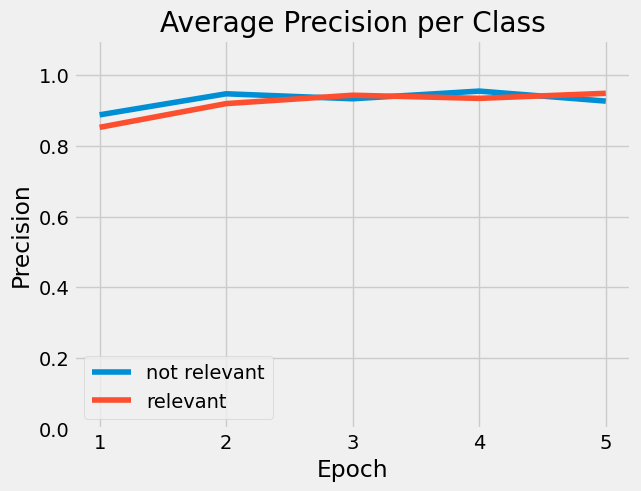

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt #changes made for relevant

# Set the style to a minimalist theme
plt.style.use('fivethirtyeight')

# changes for relevance:
plt.plot(grouped0['precision'], label = "not relevant")
plt.plot(grouped1['precision'], label = "relevant")
# plt.plot(grouped0['precision'], label = "Favourable")
# plt.plot(grouped1['precision'], label = "Unfavourable")
# plt.plot(grouped2['precision'], label = "Neutral")


# Labels

plt.title("Average Precision per Class")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1.1))
plt.legend()

plt.show()

plt.savefig(folder_path+'2020avgprecisionclass.png', format='png', transparent = True, bbox_inches='tight')

#### No title

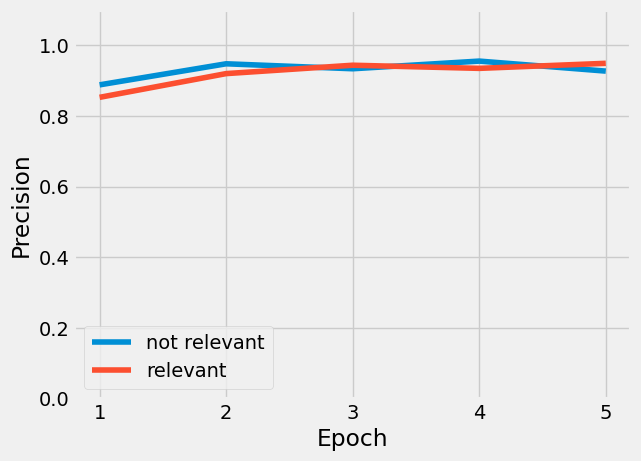

In [ ]:
# Set the style to a minimalist theme
plt.style.use('fivethirtyeight')

# changes for relevance:
plt.plot(grouped0['precision'], label = "not relevant")
plt.plot(grouped1['precision'], label = "relevant")
# plt.plot(grouped0['precision'], label = "Favourable")
# plt.plot(grouped1['precision'], label = "Unfavourable")
# plt.plot(grouped2['precision'], label = "Neutral")


# Labels

plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1.1))
plt.legend()

plt.savefig(folder_path+'2020avgprecisionclassnoleg.png', format='png', transparent = True, bbox_inches='tight')

### Recall

#### With Title

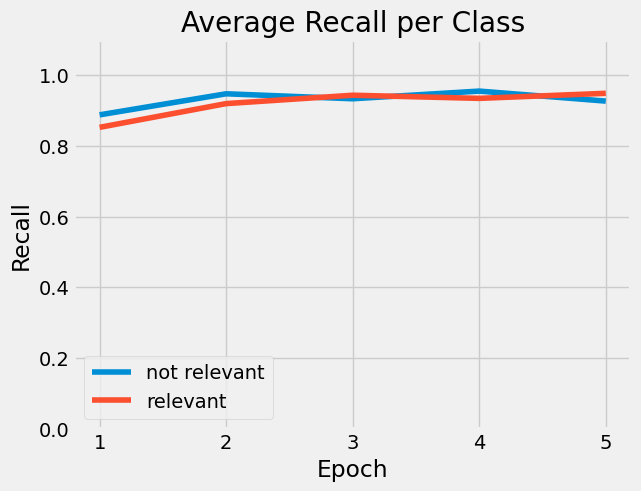

In [ ]:
# Set the style to a minimalist theme
plt.style.use('fivethirtyeight')

# changes for relevance:
plt.plot(grouped0['precision'], label = "not relevant")
plt.plot(grouped1['precision'], label = "relevant")
# plt.plot(grouped0['recall'], label = "Favourable")
# plt.plot(grouped1['recall'], label = "Unfavourable")
# plt.plot(grouped2['recall'], label = "Neutral")


# Labels

plt.title("Average Recall per Class")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1.1))
plt.legend()


plt.savefig(folder_path+'2020avgrecallclass.png', format='png', transparent = True, bbox_inches='tight')

#### No Title

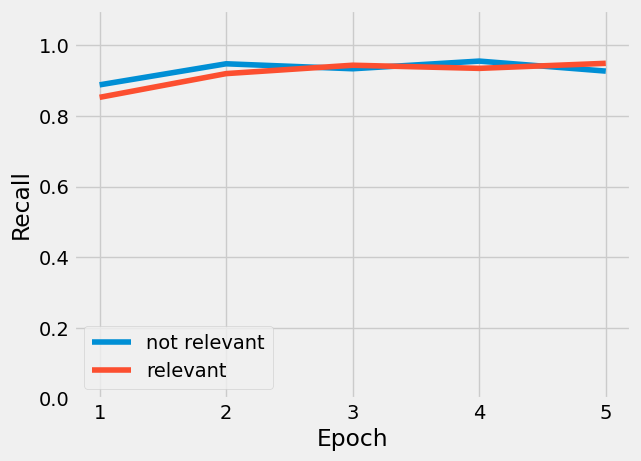

In [ ]:
# Set the style to a minimalist theme
plt.style.use('fivethirtyeight')

# changes for relevance:
plt.plot(grouped0['precision'], label = "not relevant")
plt.plot(grouped1['precision'], label = "relevant")
# plt.plot(grouped0['recall'], label = "Favourable")
# plt.plot(grouped1['recall'], label = "Unfavourable")
# plt.plot(grouped2['recall'], label = "Neutral")


# Labels

plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1.1))
plt.legend()



plt.savefig(folder_path+'2020avgrecallclassnoleg.png', format='png', transparent = True, bbox_inches='tight')

### F1-score

#### With Title

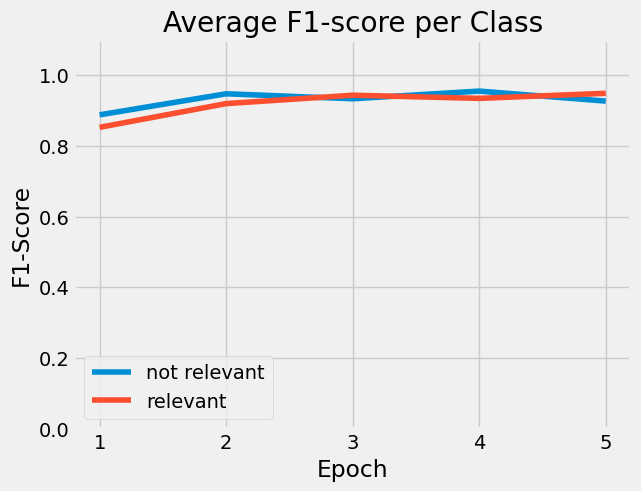

In [ ]:
# Set the style to a minimalist theme
plt.style.use('fivethirtyeight')

# changes for relevance:
plt.plot(grouped0['precision'], label = "not relevant")
plt.plot(grouped1['precision'], label = "relevant")
# plt.plot(grouped0['f1-score'], label = "Favourable")
# plt.plot(grouped1['f1-score'], label = "Unfavourable")
# plt.plot(grouped2['f1-score'], label = "Neutral")


# Labels

plt.title("Average F1-score per Class")
plt.xlabel("Epoch")
plt.ylabel("F1-Score")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1.1))
plt.legend()


plt.savefig(folder_path+'2020avgf1class.png', format='png', transparent = True, bbox_inches='tight')

#### No Title

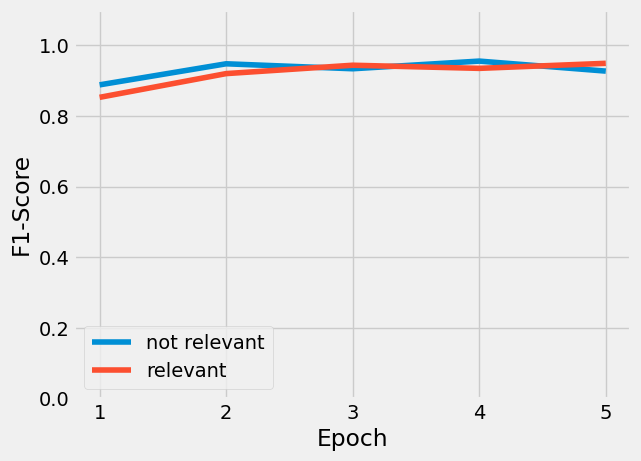

In [ ]:
# Set the style to a minimalist theme
plt.style.use('fivethirtyeight')

# changes for relevance:
plt.plot(grouped0['precision'], label = "not relevant")
plt.plot(grouped1['precision'], label = "relevant")
# plt.plot(grouped0['f1-score'], label = "Favourable")
# plt.plot(grouped1['f1-score'], label = "Unfavourable")
# plt.plot(grouped2['f1-score'], label = "Neutral")


# Labels

plt.xlabel("Epoch")
plt.ylabel("F1-Score")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1.1))
plt.legend()



plt.savefig(folder_path+'2020avgf1classnoleg.png', format='png', transparent = True, bbox_inches='tight')

### Loss

#### With Title

In [ ]:
# added cell:
import seaborn as sns

# Plot styling

sns.set(style = "darkgrid")

# Aumenttndo o tamanho do plot e da fonte

sns.set(font_scale = 1.5)
plt.rcParams['figure.figsize'] = (12,6)

# Curva de aprendizado

treino_loss = df_stats.groupby('epoch')['Training Loss'].mean()
valida_loss = df_stats.groupby('epoch')['Valid. Loss'].mean()

treino_valid = pd.merge(treino_loss, valida_loss, right_index = True,
               left_index = True)


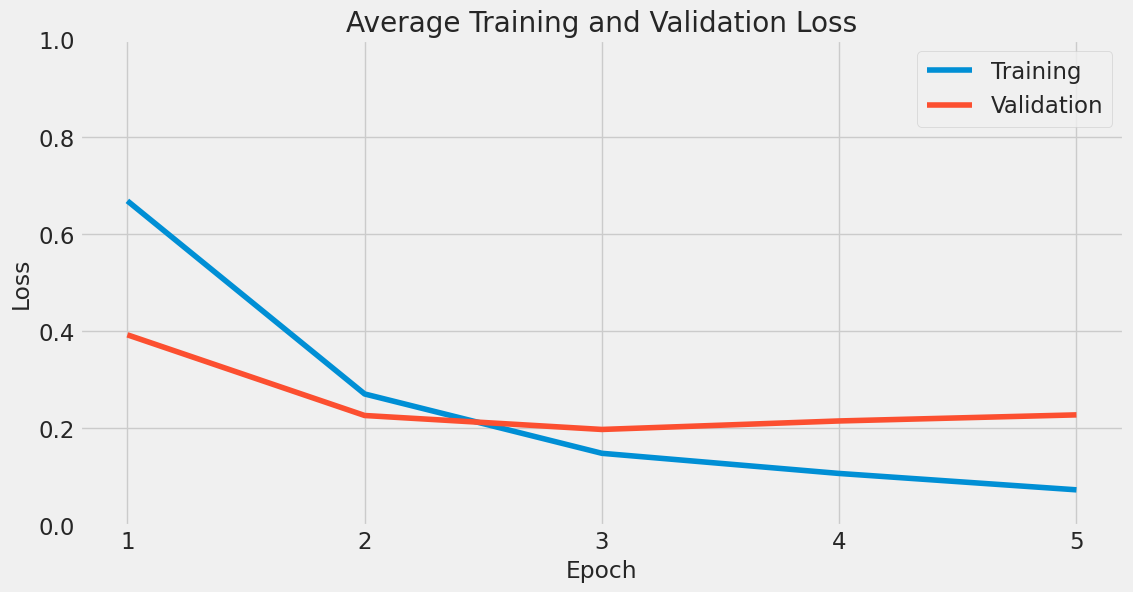

In [ ]:
# Set the style to a minimalist theme
plt.style.use('fivethirtyeight')



plt.plot(treino_valid['Training Loss'], label = "Training")
plt.plot(treino_valid['Valid. Loss'], label = "Validation")

# Labels

plt.title("Average Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1))



plt.savefig(folder_path+'2020avgloss.png', format='png', transparent = True, bbox_inches='tight')

# import matplotlib.pyplot as plt

# plt.plot(treino_valid['Training Loss'], 'b-o', label = "Training")
# plt.plot(treino_valid['Valid. Loss'], 'g-o', label = "Validation")

# # Labels

# plt.title("Average Training and Validation Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.legend()
# plt.xticks([1,2,3,4,5])
# plt.ylim((0, 1))



# plt.savefig(folder_path+'2020avgloss.png', format='png', transparent = True, bbox_inches='tight')

#### No Title

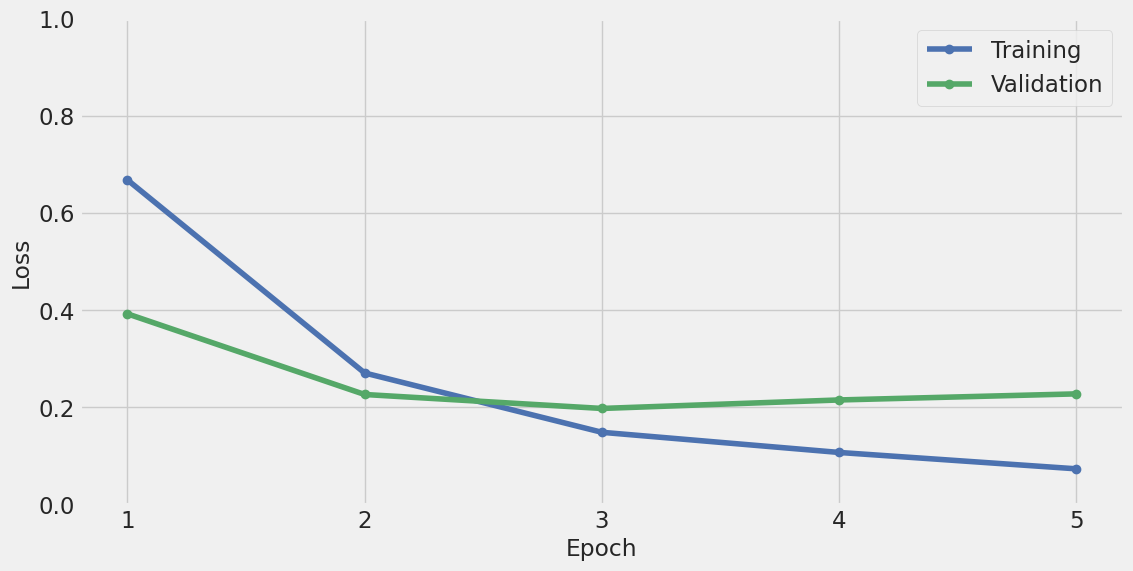

In [ ]:
plt.plot(treino_valid['Training Loss'], 'b-o', label = "Training")
plt.plot(treino_valid['Valid. Loss'], 'g-o', label = "Validation")

# Labels

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1))




plt.savefig(folder_path+'2020avglossnoleg.png', format='png', transparent = True, bbox_inches='tight')

## Test Set Predictions


---

In [ ]:
# ========================================
#               Test Set
# ========================================

print('\nTest Set...')

model_preds_list = []

print('Total batches:', len(test_dataloader))

fold_no = 0

for fold_no in range(0, NUM_FOLDS_TO_TRAIN):

    print('\nFold Model', fold_no)

    # Load the fold model
    path_model = 'model_' + str(fold_no) + '.bin'
    model.load_state_dict(torch.load(path_model))

    # Send the model to the device.
    model.to(device)


    stacked_val_labels = []


    # Put the model in evaluation mode.
    model.eval()

    # Turn off the gradient calculations.
    # This tells the model not to compute or store gradients.
    # This step saves memory and speeds up validation.
    torch.set_grad_enabled(False)


    # Reset the total loss for this epoch.
    total_val_loss = 0

    for j, h_batch in enumerate(test_dataloader):

        inference_status = 'Batch ' + str(j + 1)

        print(inference_status, end='\r')

        b_input_ids = h_batch[0].to(device)
        b_input_mask = h_batch[1].to(device)
        b_token_type_ids = h_batch[2].to(device)


        outputs = model(b_input_ids,
                token_type_ids=b_token_type_ids,
                attention_mask=b_input_mask)


        # Get the preds
        preds = outputs[0]


        # Move preds to the CPU
        val_preds = preds.detach().cpu().numpy()


        # Stack the predictions.

        if j == 0:  # first batch
            stacked_val_preds = val_preds

        else:
            stacked_val_preds = np.vstack((stacked_val_preds, val_preds))


    model_preds_list.append(stacked_val_preds)


print('\nPrediction complete.')


Test Set...
Total batches: 6

Fold Model 0
Batch 6
Fold Model 1
Batch 6
Fold Model 2
Batch 6
Fold Model 3
Batch 6
Fold Model 4
Batch 6
Prediction complete.


In [ ]:
model_preds_list

[array([[-1.920736  ,  4.197056  , -1.900763  ],
        [-2.16423   ,  4.2282724 , -1.6332184 ],
        [-2.0423076 ,  4.187046  , -1.7176201 ],
        [ 3.3260593 , -1.7397946 , -2.1684525 ],
        [-2.0231924 ,  4.1748753 , -1.7819303 ],
        [ 3.5376596 , -1.7746941 , -2.4429374 ],
        [ 3.304283  , -1.5851638 , -2.225574  ],
        [ 3.3612971 , -2.1405227 , -1.8211491 ],
        [-2.247129  ,  4.179887  , -1.5292797 ],
        [-1.9624258 ,  4.021529  , -1.6153897 ],
        [-2.1921997 ,  4.210197  , -1.5431114 ],
        [ 2.54146   , -0.16870356, -3.0695503 ],
        [-2.0830524 ,  4.176276  , -1.6623797 ],
        [ 3.1865692 , -0.77280873, -2.8737605 ],
        [-2.2053144 ,  4.178119  , -1.5779811 ],
        [-1.5407047 ,  4.030214  , -2.1536815 ],
        [ 3.4226527 , -1.669879  , -2.2107074 ],
        [ 2.3682308 ,  0.49316752, -3.4321346 ],
        [-2.1446767 ,  4.1954675 , -1.6761686 ],
        [-2.27417   ,  4.1316967 , -1.4332812 ],
        [ 3.4706767 

### Results - Average Fold Results

Here are the results using the average prediction over all folds.

In [ ]:
# Take the argmax. This returns the column index of the max value in each row.

# Sum the predictions of all fold models
for i, item in enumerate(model_preds_list):

    if i == 0:

        preds = item

    else:

        # Sum the matrices
        preds = item + preds


# Average the predictions
avg_preds = preds/(len(model_preds_list))


test_preds = np.argmax(avg_preds, axis=1)

In [ ]:
# changes for relevant:
accuracy_score(df_test[RELEVANCE], test_preds)
# accuracy_score(df_test['positions_vac'], test_preds)

0.937888198757764

In [ ]:
# changes for relevant:
print(classification_report(df_test[RELEVANCE], test_preds, labels = [0,1,2]))
# print(classification_report(df_test['positions_vac'], test_preds, labels = [0,1,2]))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92        64
           1       0.95      0.95      0.95        97
           2       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94       161
   macro avg       0.62      0.62      0.62       161
weighted avg       0.94      0.94      0.94       161



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy

# changes for relevant:
confusion_matrix = metrics.confusion_matrix(df_test[RELEVANCE], test_preds)
# confusion_matrix = metrics.confusion_matrix(df_test['positions_vac'], test_preds)

confusion_matrix

array([[59,  5],
       [ 5, 92]])

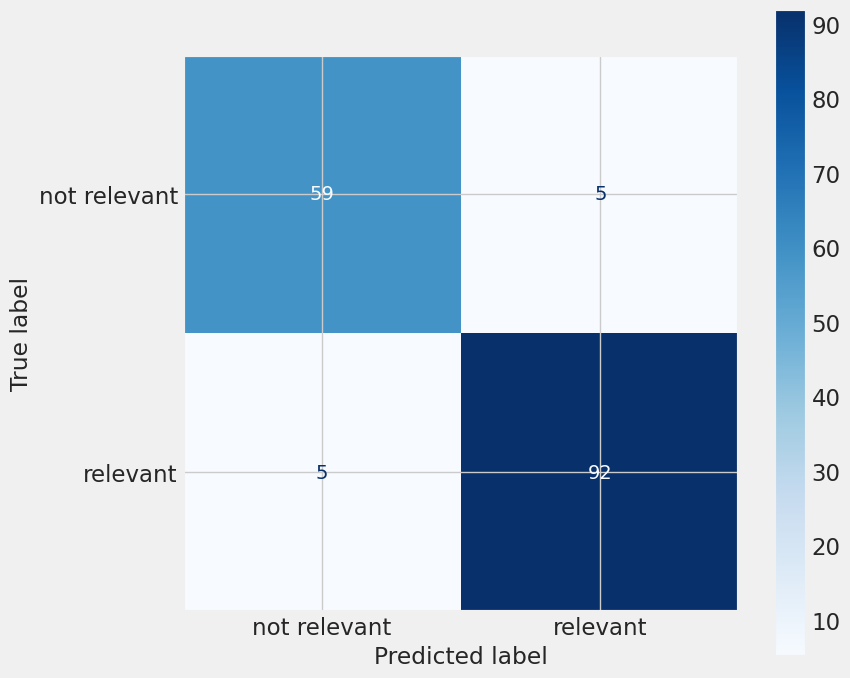

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_predictions(
                  # changes for relevante
                  df_test[RELEVANCE],
                  # df_test['positions_vac'],
                  test_preds,
                  # changes for relevante
                  labels=[0,1],
                  # labels=[0,1,2],
                  cmap=plt.cm.Blues,
                  # changes for relevante
                  display_labels=['not relevant','relevant'],
                  # display_labels=['Positive','Negative', 'Neutral'],
                  values_format='',
)
fig = disp.ax_.get_figure()
fig.set_figwidth(8)
fig.set_figheight(8)

### Best Fold Results

---



Below are the results of the predictions of the best model alone.

In [ ]:
# Summary of the Training Process

pd.set_option('display.precision', 2)

# Creating a dataframe with our training results

df_stats = pd.DataFrame(data = training_stats)

# Using Epoch as an index

df_stats = df_stats.set_index('fold')

# Getting the Fold with the best F1-Macro

bestsplit = df_stats['macro_f1_score'].idxmax()

df_stats['macro_f1_score'].idxmax()

2

In [ ]:
# Take the argmax. This returns the column index of the max value in each row.

# Sum the predictions of all fold models
for i, item in enumerate(model_preds_list):

    if i == bestsplit:
        preds_bestsplit = item


bestsplit_preds = np.argmax(preds_bestsplit, axis=1)

In [ ]:
# changes for relevante:
accuracy_score(df_test[RELEVANCE], bestsplit_preds)
# accuracy_score(df_test['positions_vac'], bestsplit_preds)

0.9440993788819876

In [ ]:
# changes for relevante:
print(classification_report(df_test[RELEVANCE], bestsplit_preds, labels = [0,1]))
# print(classification_report(df_test['positions_vac'], bestsplit_preds, labels = [0,1,2]))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93        64
           1       0.96      0.95      0.95        97

    accuracy                           0.94       161
   macro avg       0.94      0.94      0.94       161
weighted avg       0.94      0.94      0.94       161



In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy

# changes for relevante:
confusion_matrix = metrics.confusion_matrix(df_test[RELEVANCE], bestsplit_preds)
# confusion_matrix = metrics.confusion_matrix(df_test['positions_vac'], bestsplit_preds)

confusion_matrix

array([[60,  4],
       [ 5, 92]])

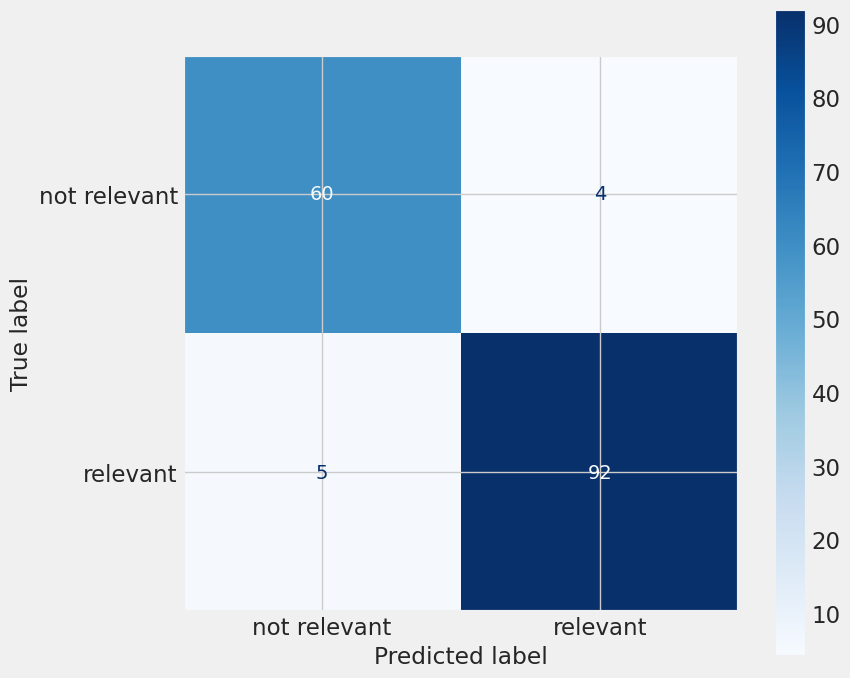

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_predictions(
                  # changes for relevante
                  df_test[RELEVANCE],
                  # df_test['positions_vac'],
                  bestsplit_preds,

                  # changes for relevante
                  labels=[0,1],
                  # labels=[0,1,2],
                  cmap=plt.cm.Blues,
                  # changes for relevante
                  display_labels=['not relevant','relevant'],
                  # display_labels=['Positive','Negative', 'Neutral'],
                  values_format='',
)
fig = disp.ax_.get_figure()
fig.set_figwidth(8)
fig.set_figheight(8)